<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/AD_March12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented")

print("Path to dataset files:", path)

100%|██████████| 398M/398M [00:20<00:00, 20.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented/versions/1


The dataset is organized into the following four directories, each representing a different class of disease severity:
NonDemented: Contains 12,800 MRI images of subjects with no signs of dementia.
VeryMildDemented: Contains 11,200 MRI images of subjects with very mild symptoms of dementia.
MildDemented: Contains 10,000 MRI images of subjects with mild dementia.
ModerateDemented: Contains 10,000 MRI images of subjects with moderate dementia.
<br>
Image Details
Total Number of Images: 44,000
Image Format: MRI scans as .JPG files

Step 1: Exploratory Data Analysis (EDA)
Total images in dataset: 0


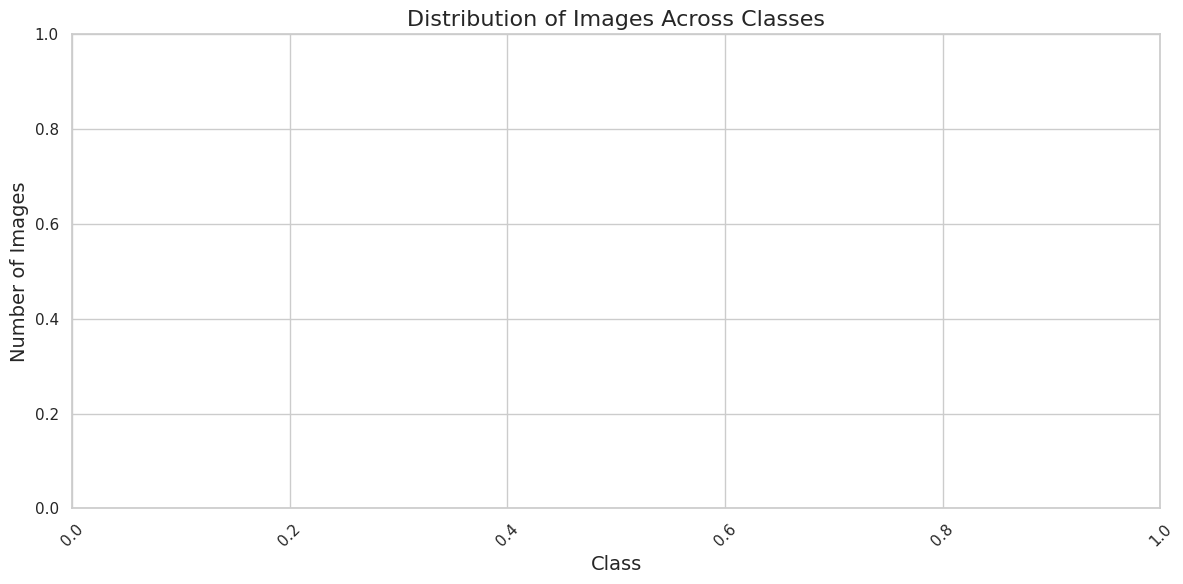

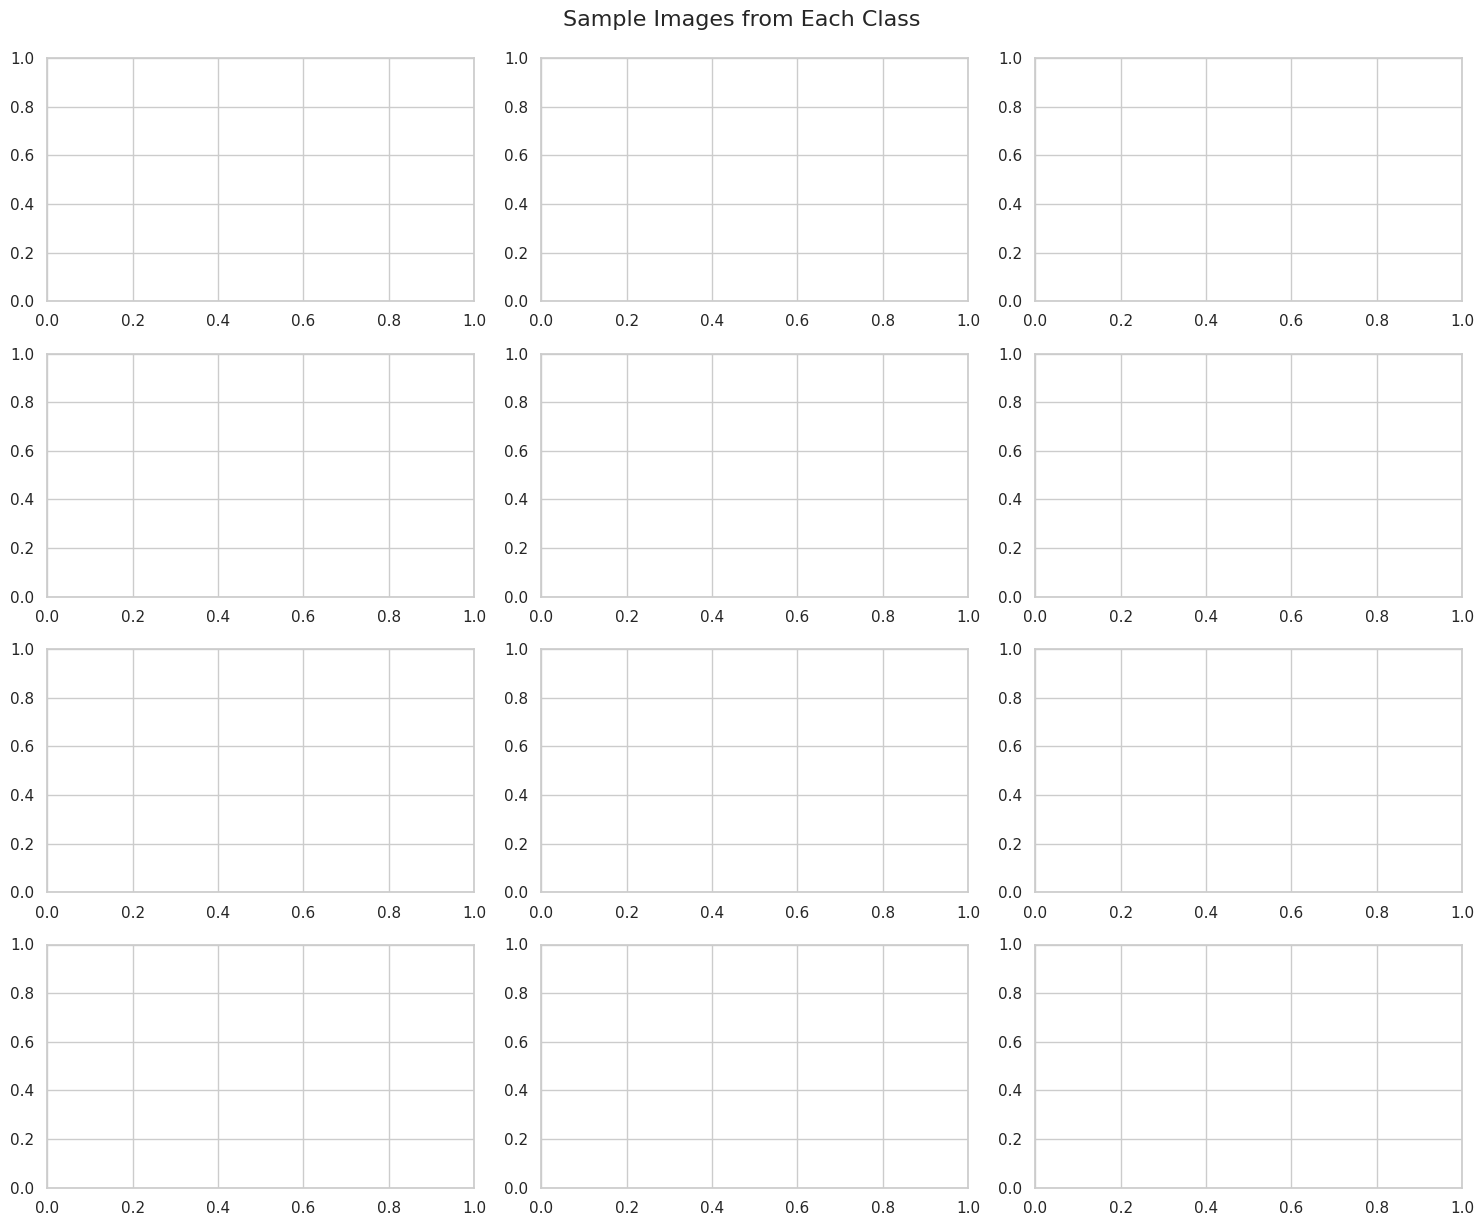

<ipython-input-3-d1a32ee04f22>:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


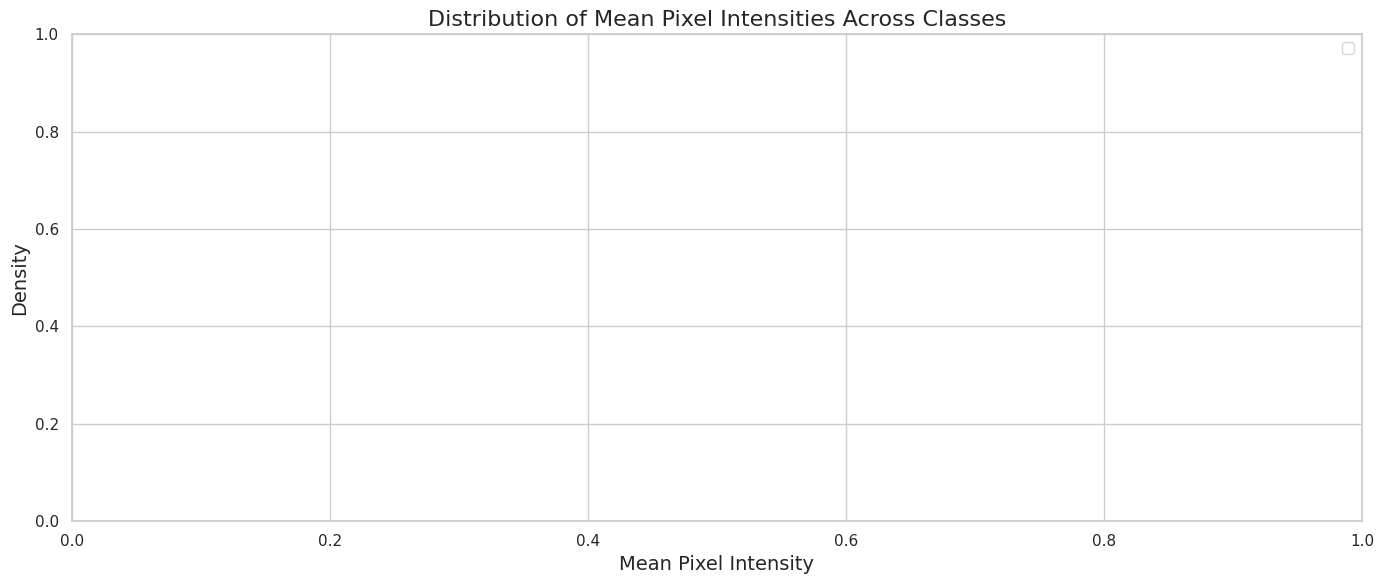


Image Intensity Statistics:

Step 2: Data Preprocessing


ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Step 1: Exploratory Data Analysis (EDA)
print("Step 1: Exploratory Data Analysis (EDA)")

# Assuming the dataset is downloaded to 'path'
# Replace with your actual path if needed
path = "aryansinghal10_alzheimers-multiclass-dataset-equal-and-augmented"

# Define class directories
class_dirs = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Function to get dataset statistics
def get_dataset_stats(base_path, class_directories):
    stats = {}
    total_images = 0

    for class_dir in class_directories:
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(image_files)
            total_images += num_images
            stats[class_dir] = {
                'count': num_images,
                'example_files': image_files[:3] if num_images >= 3 else image_files
            }

            # Get image dimensions for a sample image
            if num_images > 0:
                sample_img_path = os.path.join(dir_path, image_files[0])
                with Image.open(sample_img_path) as img:
                    stats[class_dir]['image_dimensions'] = img.size

    return stats, total_images

# Get dataset statistics
dataset_stats, total_count = get_dataset_stats(path, class_dirs)

# Display overall dataset information
print(f"Total images in dataset: {total_count}")
for class_name, info in dataset_stats.items():
    print(f"\n{class_name}:")
    print(f"  - Number of images: {info['count']}")
    print(f"  - Image dimensions: {info.get('image_dimensions', 'N/A')}")
    print(f"  - Sample filenames: {', '.join(info.get('example_files', ['N/A']))[:100]}...")

# Visualize class distribution
classes = list(dataset_stats.keys())
counts = [dataset_stats[cls]['count'] for cls in classes]

plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts)
plt.title('Distribution of Images Across Classes', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Function to display sample images from each class
def show_sample_images(base_path, class_directories, samples_per_class=3):
    num_classes = len(class_directories)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 12))

    for i, class_dir in enumerate(class_directories):
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            if image_files:
                # Select random sample images
                selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))

                for j, img_file in enumerate(selected_images):
                    img_path = os.path.join(dir_path, img_file)
                    img = Image.open(img_path)
                    axes[i, j].imshow(img, cmap='gray')
                    axes[i, j].set_title(f"{class_dir}\n{img_file[:10]}...", fontsize=10)
                    axes[i, j].axis('off')

    plt.tight_layout()
    plt.suptitle('Sample Images from Each Class', fontsize=16, y=1.02)
    plt.show()

# Show sample images
show_sample_images(path, class_dirs)

# Function to analyze image properties
def analyze_image_properties(base_path, class_directories, samples_per_class=50):
    intensities = {cls: [] for cls in class_directories}
    sizes = {cls: [] for cls in class_directories}

    for class_dir in class_directories:
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            if image_files:
                # Select random sample images
                selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))

                for img_file in selected_images:
                    img_path = os.path.join(dir_path, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Calculate mean intensity
                        intensities[class_dir].append(np.mean(img))
                        # Store image size (height × width)
                        sizes[class_dir].append(img.shape[0] * img.shape[1])

    # Plot intensity distributions
    plt.figure(figsize=(14, 6))
    for cls in class_directories:
        if intensities[cls]:
            sns.kdeplot(intensities[cls], label=cls)
    plt.title('Distribution of Mean Pixel Intensities Across Classes', fontsize=16)
    plt.xlabel('Mean Pixel Intensity', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate and print statistics about image properties
    intensity_stats = {cls: {'mean': np.mean(intensities[cls]), 'std': np.std(intensities[cls])}
                      for cls in class_directories if intensities[cls]}

    print("\nImage Intensity Statistics:")
    for cls, stats in intensity_stats.items():
        print(f"{cls}: Mean={stats['mean']:.2f}, Std={stats['std']:.2f}")

# Analyze image properties
analyze_image_properties(path, class_dirs)

# Step 2: Data Preprocessing
print("\nStep 2: Data Preprocessing")

# Function to create a labeled dataset
def create_labeled_dataset(base_path, class_directories):
    image_paths = []
    labels = []

    for idx, class_dir in enumerate(class_directories):
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in image_files:
                img_path = os.path.join(dir_path, img_file)
                image_paths.append(img_path)
                labels.append(idx)  # Use index as the numeric label

    return np.array(image_paths), np.array(labels)

# Create labeled dataset
image_paths, labels = create_labeled_dataset(path, class_dirs)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# Print distribution in each split
def print_class_distribution(y, class_names):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip([class_names[i] for i in unique], counts))
    for cls, count in distribution.items():
        print(f"  - {cls}: {count} images ({count/len(y)*100:.2f}%)")

print("\nClass distribution in train set:")
print_class_distribution(y_train, class_dirs)
print("\nClass distribution in validation set:")
print_class_distribution(y_val, class_dirs)
print("\nClass distribution in test set:")
print_class_distribution(y_test, class_dirs)

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image
    img = cv2.resize(img, target_size)

    # Normalize pixel values to [0, 1]
    img = img / 255.0

    return img

# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Do not augment validation/test data
val_datagen = ImageDataGenerator()

# Show original vs augmented images
def show_augmented_images(image_path, datagen, num_augmentations=3):
    # Load original image
    original_img = load_and_preprocess_image(image_path)
    if original_img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Create a batch of single image and reshape
    img_batch = np.expand_dims(original_img, 0)

    # Generate augmented images
    aug_iter = datagen.flow(img_batch, batch_size=1)

    # Plot original and augmented images
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 4))

    # Display original image
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display augmented images
    for i in range(num_augmentations):
        aug_img = aug_iter.next()[0]
        axes[i+1].imshow(aug_img)
        axes[i+1].set_title(f'Augmented #{i+1}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

# Show augmentation examples for each class
for class_dir in class_dirs:
    dir_path = os.path.join(path, class_dir)
    if os.path.exists(dir_path):
        image_files = [f for f in os.listdir(dir_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if image_files:
            sample_img_path = os.path.join(dir_path, random.choice(image_files))
            print(f"\nAugmentation examples for class: {class_dir}")
            show_augmented_images(sample_img_path, train_datagen)

# Create a preprocessing function suitable for a deep learning pipeline
def preprocess_pipeline(dataset_path, class_dirs, img_size=(224, 224), batch_size=32):
    # Create train generator with augmentation
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # 20% for validation
    )

    # Create generators
    train_generator = train_gen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        classes=class_dirs
    )

    validation_generator = train_gen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        classes=class_dirs
    )

    return train_generator, validation_generator

print("\nExample of how to use the preprocessing pipeline for model training:")
print("train_generator, validation_generator = preprocess_pipeline(path, class_dirs)")
print("model.fit(train_generator, validation_data=validation_generator, ...)")

# Save preprocessed data to file (example)
def save_preprocessed_data(X_train, y_train, X_val, y_val, X_test, y_test, output_dir="preprocessed_data"):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save data splits
    np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(output_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(output_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

    print(f"\nPreprocessed data saved to {output_dir}")

# Example of saving preprocessed data (commented out to prevent accidental execution)
# save_preprocessed_data(X_train, y_train, X_val, y_val, X_test, y_test)

print("\nEDA and preprocessing completed successfully!")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Set style for plots
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')

# Step 1: Exploratory Data Analysis (EDA)
print("Step 1: Exploratory Data Analysis (EDA)")

# Path verification - add this to check if the path exists and contains the expected directories
# Replace this with your actual path from kagglehub.dataset_download
path = "aryansinghal10_alzheimers-multiclass-dataset-equal-and-augmented"

# Verify path exists
print(f"Checking if dataset path exists: {os.path.exists(path)}")

# List available directories/files at the path
if os.path.exists(path):
    print("Contents at path:")
    print(os.listdir(path))
else:
    print("Path does not exist. Please check the dataset download path.")

    # Try common alternative structures
    parent_dir = os.path.dirname(path)
    if os.path.exists(parent_dir):
        print(f"Parent directory exists. Contents of parent directory:")
        print(os.listdir(parent_dir))

        # Check for dataset folders at the current directory
        current_dir = os.getcwd()
        print(f"Contents of current working directory ({current_dir}):")
        print(os.listdir(current_dir))

        # Look for directories that might contain the classes
        for item in os.listdir(current_dir):
            if os.path.isdir(item):
                sub_items = os.listdir(item)
                print(f"Contents of {item}:")
                print(sub_items)

                # Check if this directory contains the class folders
                if any(cls in sub_items for cls in ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']):
                    print(f"Found class directories in: {item}")
                    path = item
                    break

# Define class directories
class_dirs = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Function to recursively search for class directories
def find_class_directories(start_path, class_names, max_depth=3, current_depth=0):
    if current_depth > max_depth:
        return None

    # Check if any class directories exist at this level
    found_classes = [cls for cls in class_names if os.path.isdir(os.path.join(start_path, cls))]
    if found_classes:
        return start_path

    # Check subdirectories
    for item in os.listdir(start_path):
        item_path = os.path.join(start_path, item)
        if os.path.isdir(item_path):
            result = find_class_directories(item_path, class_names, max_depth, current_depth + 1)
            if result:
                return result

    return None

# Try to find the class directories
if os.path.exists(path):
    dataset_path = find_class_directories(path, class_dirs)
    if dataset_path:
        print(f"Found class directories at: {dataset_path}")
        path = dataset_path
    else:
        print("Could not find class directories in the dataset path.")

        # Check current directory
        current_dir = os.getcwd()
        dataset_path = find_class_directories(current_dir, class_dirs)
        if dataset_path:
            print(f"Found class directories at: {dataset_path}")
            path = dataset_path

# Function to get dataset statistics
def get_dataset_stats(base_path, class_directories):
    stats = {}
    total_images = 0

    for class_dir in class_directories:
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(image_files)
            total_images += num_images
            stats[class_dir] = {
                'count': num_images,
                'example_files': image_files[:3] if num_images >= 3 else image_files
            }

            # Get image dimensions for a sample image
            if num_images > 0:
                sample_img_path = os.path.join(dir_path, image_files[0])
                with Image.open(sample_img_path) as img:
                    stats[class_dir]['image_dimensions'] = img.size

    return stats, total_images

# Get dataset statistics
dataset_stats, total_count = get_dataset_stats(path, class_dirs)

# Display overall dataset information
print(f"Total images in dataset: {total_count}")
for class_name, info in dataset_stats.items():
    print(f"\n{class_name}:")
    print(f"  - Number of images: {info['count']}")
    print(f"  - Image dimensions: {info.get('image_dimensions', 'N/A')}")
    if 'example_files' in info and info['example_files']:
        example_files_str = ', '.join(info['example_files'][:3])
        print(f"  - Sample filenames: {example_files_str}")

# Verify we have data before proceeding
if total_count == 0:
    print("No images found in the dataset. Please check the path and directory structure.")
    print("Exiting script.")
    import sys
    sys.exit(1)

# Visualize class distribution
classes = list(dataset_stats.keys())
counts = [dataset_stats[cls]['count'] for cls in classes]

plt.figure(figsize=(12, 6))
sns.barplot(x=classes, y=counts)
plt.title('Distribution of Images Across Classes', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Function to display sample images from each class
def show_sample_images(base_path, class_directories, samples_per_class=3):
    num_classes = len(class_directories)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 12))

    for i, class_dir in enumerate(class_directories):
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if image_files:
                # Select random sample images
                selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))

                for j, img_file in enumerate(selected_images):
                    img_path = os.path.join(dir_path, img_file)
                    try:
                        img = Image.open(img_path)
                        axes[i, j].imshow(img, cmap='gray')
                        axes[i, j].set_title(f"{class_dir}\n{img_file[:10]}...", fontsize=10)
                        axes[i, j].axis('off')
                    except Exception as e:
                        print(f"Error displaying image {img_path}: {e}")

    plt.tight_layout()
    plt.suptitle('Sample Images from Each Class', fontsize=16, y=1.02)
    plt.show()

# Show sample images
show_sample_images(path, class_dirs)

# Function to analyze image properties
def analyze_image_properties(base_path, class_directories, samples_per_class=50):
    intensities = {cls: [] for cls in class_directories}
    sizes = {cls: [] for cls in class_directories}

    for class_dir in class_directories:
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if image_files:
                # Select random sample images
                selected_images = random.sample(image_files, min(samples_per_class, len(image_files)))

                for img_file in selected_images:
                    img_path = os.path.join(dir_path, img_file)
                    try:
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            # Calculate mean intensity
                            intensities[class_dir].append(np.mean(img))
                            # Store image size (height × width)
                            sizes[class_dir].append(img.shape[0] * img.shape[1])
                    except Exception as e:
                        print(f"Error analyzing image {img_path}: {e}")

    # Check if we have data to plot
    has_data = any(len(intensities[cls]) > 0 for cls in class_directories)
    if not has_data:
        print("No image data could be analyzed. Please check image formats and paths.")
        return

    # Plot intensity distributions
    plt.figure(figsize=(14, 6))
    for cls in class_directories:
        if intensities[cls]:
            sns.kdeplot(intensities[cls], label=cls)
    plt.title('Distribution of Mean Pixel Intensities Across Classes', fontsize=16)
    plt.xlabel('Mean Pixel Intensity', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate and print statistics about image properties
    intensity_stats = {cls: {'mean': np.mean(intensities[cls]), 'std': np.std(intensities[cls])}
                      for cls in class_directories if intensities[cls]}

    print("\nImage Intensity Statistics:")
    for cls, stats in intensity_stats.items():
        print(f"{cls}: Mean={stats['mean']:.2f}, Std={stats['std']:.2f}")

# Analyze image properties
analyze_image_properties(path, class_dirs)

# Step 2: Data Preprocessing
print("\nStep 2: Data Preprocessing")

# Function to create a labeled dataset
def create_labeled_dataset(base_path, class_directories):
    image_paths = []
    labels = []

    for idx, class_dir in enumerate(class_directories):
        dir_path = os.path.join(base_path, class_dir)
        if os.path.exists(dir_path):
            image_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in image_files:
                img_path = os.path.join(dir_path, img_file)
                image_paths.append(img_path)
                labels.append(idx)  # Use index as the numeric label

    return np.array(image_paths), np.array(labels)

# Create labeled dataset
image_paths, labels = create_labeled_dataset(path, class_dirs)

# Check if we have data before splitting
if len(image_paths) == 0:
    print("No images found to process. Please check path and image formats.")
    import sys
    sys.exit(1)

print(f"Total number of images found: {len(image_paths)}")
print(f"Label distribution: {np.bincount(labels)}")

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

# Print distribution in each split
def print_class_distribution(y, class_names):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip([class_names[int(i)] for i in unique], counts))
    for cls, count in distribution.items():
        print(f"  - {cls}: {count} images ({count/len(y)*100:.2f}%)")

print("\nClass distribution in train set:")
print_class_distribution(y_train, class_dirs)
print("\nClass distribution in validation set:")
print_class_distribution(y_val, class_dirs)
print("\nClass distribution in test set:")
print_class_distribution(y_test, class_dirs)

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        # Convert from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image
        img = cv2.resize(img, target_size)

        # Normalize pixel values to [0, 1]
        img = img / 255.0

        return img
    except Exception as e:
        print(f"Error preprocessing image {img_path}: {e}")
        return None

# Set up data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Do not augment validation/test data
val_datagen = ImageDataGenerator()

# Show original vs augmented images
def show_augmented_images(image_path, datagen, num_augmentations=3):
    # Load original image
    original_img = load_and_preprocess_image(image_path)
    if original_img is None:
        print(f"Error: Could not load image at {image_path}")
        return

    # Create a batch of single image and reshape
    img_batch = np.expand_dims(original_img, 0)

    # Generate augmented images
    aug_iter = datagen.flow(img_batch, batch_size=1)

    # Plot original and augmented images
    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 4))

    # Display original image
    axes[0].imshow(original_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Display augmented images
    for i in range(num_augmentations):
        aug_img = aug_iter.next()[0]
        axes[i+1].imshow(aug_img)
        axes[i+1].set_title(f'Augmented #{i+1}')
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

Step 1: Exploratory Data Analysis (EDA)
Checking if dataset path exists: False
Path does not exist. Please check the dataset download path.
Total images in dataset: 0
No images found in the dataset. Please check the path and directory structure.
Exiting script.


SystemExit: 1

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


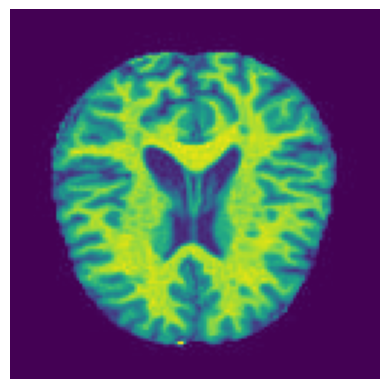

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Assuming the image is stored under the key 'image' in the dataset
image = dataset[0]['image']

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

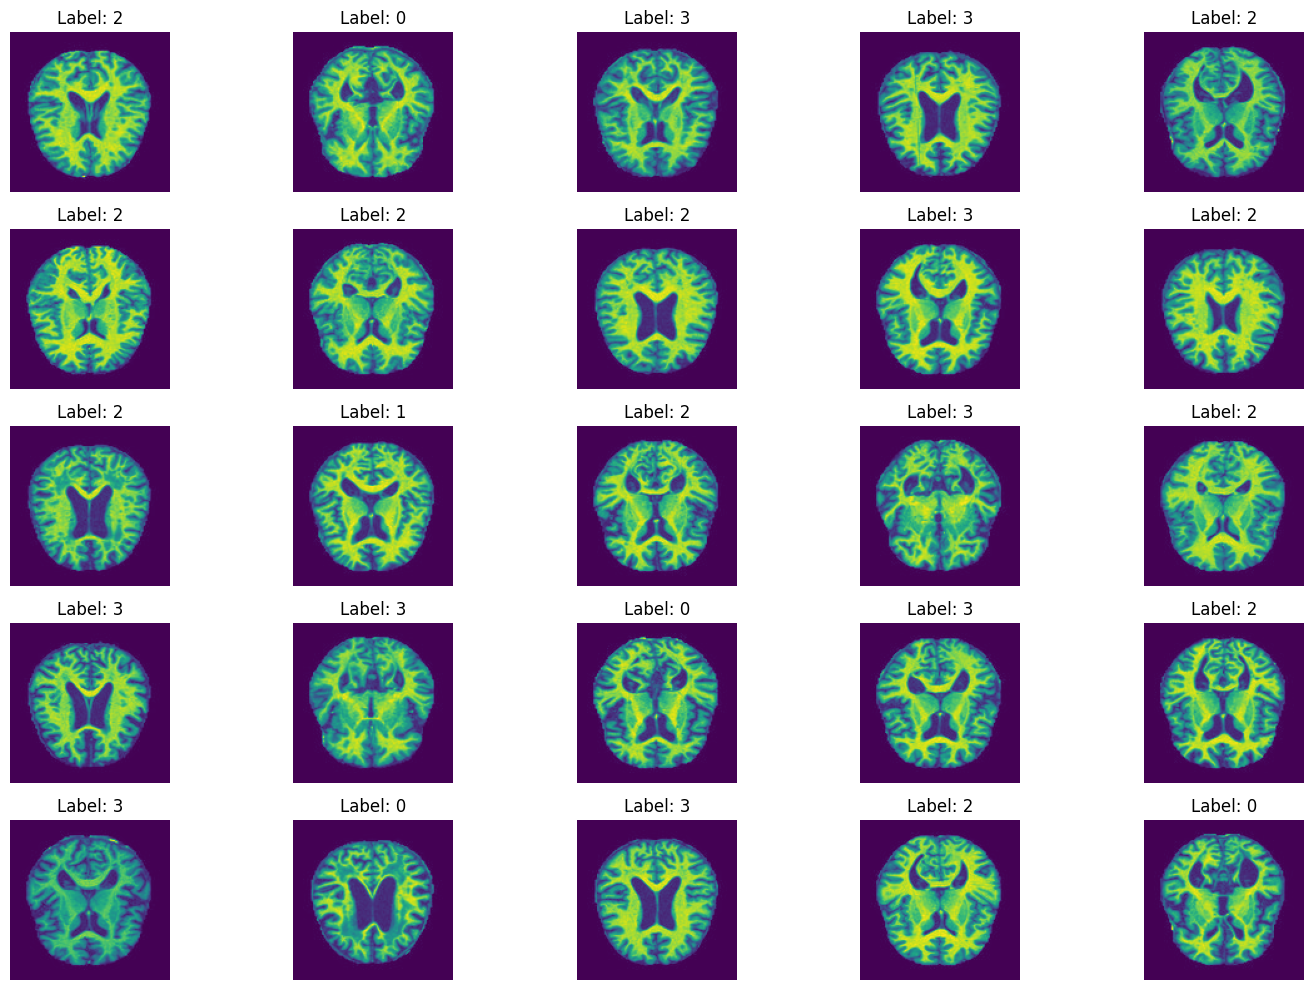

In [ ]:
# Display 25 images with their labels
plt.figure(figsize=(15, 10))  # Set the figure size
for i in range(25):
    # Get the image and label
    image = dataset[i]['image']
    label = dataset[i]['label']

    # Plot the image
    plt.subplot(5, 5, i + 1)  # Arrange images in a grid (2 rows, 5 columns)
    plt.imshow(image)  # Display the image
    plt.title(f"Label: {label}")  # Set the title as the label
    plt.axis('off')  # Hide the axes

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

Label distribution: Counter({2: 2566, 3: 1781, 0: 724, 1: 49})


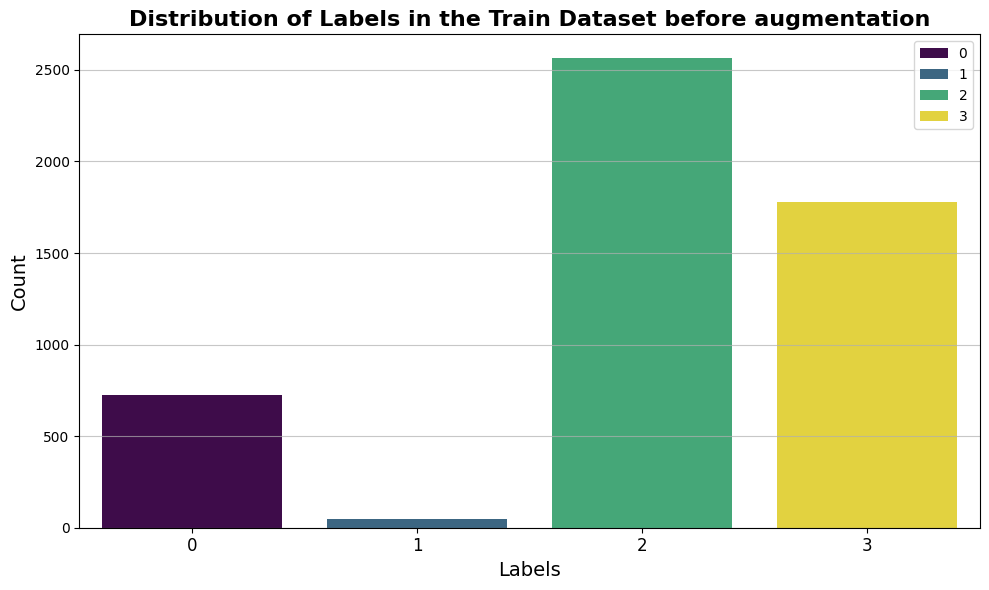

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Extract labels (assuming the key is 'label')
labels = [int(example['label']) for example in dataset]  # Convert labels to integers

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label distribution
print("Label distribution:", label_counts)

# Set a better color palette
sns.set_palette("muted")

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis",hue=list(label_counts.keys()))

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels in the Train Dataset before augmentation', fontsize=16, fontweight='bold')

# Add grid lines for better readability
plt.grid(True, axis='y', linestyle='-', alpha=0.7)

# Customize x-axis to show only integer labels
plt.xticks(list(label_counts.keys()), fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

Label distribution: Counter({2: 634, 3: 459, 0: 172, 1: 15})


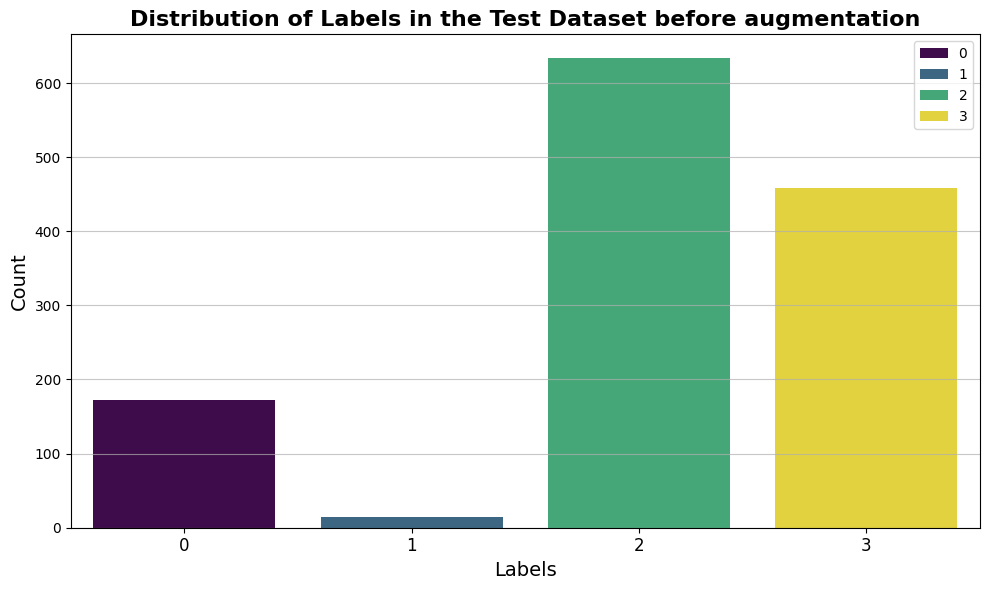

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# Extract labels (assuming the key is 'label')
labels = [int(example['label']) for example in dataset]  # Convert labels to integers

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label distribution
print("Label distribution:", label_counts)

# Set a better color palette
sns.set_palette("pastel")  # You can choose other palettes like "deep", "muted", "bright", etc.

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette="viridis",hue=list(label_counts.keys()))

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels in the Test Dataset before augmentation', fontsize=16, fontweight='bold')

# Add grid lines for better readability
plt.grid(True, axis='y', linestyle='-', alpha=0.7)

# Customize x-axis to show only integer labels
plt.xticks(list(label_counts.keys()), fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

> Data augmentation is a powerful technique to increase the diversity of your training dataset by applying random transformations such as rotations, flips, zooms, and more. This helps improve the generalization of your model, especially when the dataset is small or imbalanced.



Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape before augmentation: (128, 128, 3)
Shape after augmentation: (128, 128, 3)
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape before augmentation: (128, 128, 3)
Shape after augmentation: (128, 128, 3)
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape before augmentation: (128, 128, 3)
Shape after augmentation: (128, 128, 3)
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape before augmentation: (128, 128, 3)
Shape after augmentation: (128, 128, 3)
Image type: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Shape before augmentation: (128, 128, 3)
Shape after augmentation: (128, 128, 3)


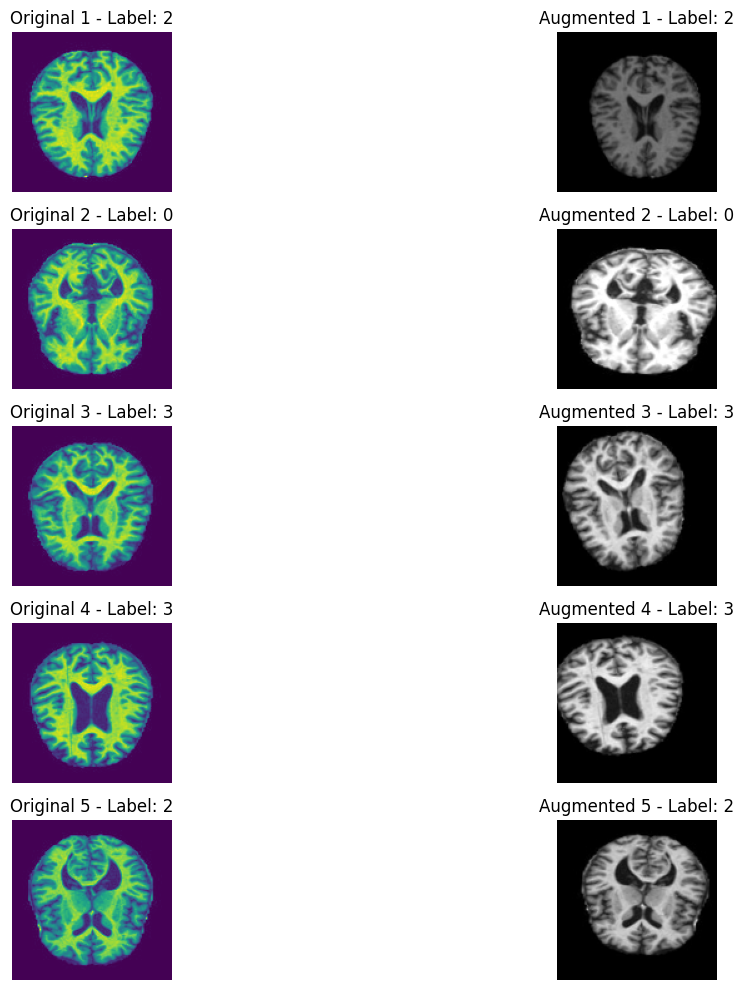

In [ ]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define augmentation transformations
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,       # Randomly rotate by up to 15 degrees
    width_shift_range=0.1,   # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    horizontal_flip=True,    # Randomly flip horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    zoom_range=0.2,          # Randomly zoom by up to 20%
)

# Function to apply augmentation to an image
def augment_image(image):
    # Convert PIL image to NumPy array if necessary
    if not isinstance(image, np.ndarray):
        image = np.array(image)  # Convert PIL image to NumPy array

    # Ensure the image has 3 channels (RGB)
    if len(image.shape) == 2:  # If grayscale, convert to RGB
        image = np.stack((image,) * 3, axis=-1)  # Shape: (height, width, 3)
    elif len(image.shape) == 3 and image.shape[-1] == 4:  # If RGBA, convert to RGB
        image = image[:, :, :3]  # Keep only the first 3 channels

    # Print the shape of the image before augmentation
    print(f"Shape before augmentation: {image.shape}")

    # Add batch dimension: (1, height, width, channels)
    image = np.expand_dims(image, axis=0)

    # Apply augmentation
    augmented_image = next(datagen.flow(image, batch_size=1))[0]  # Use next() to get the augmented image

    # Print the shape of the image after augmentation
    print(f"Shape after augmentation: {augmented_image.shape}")

    return augmented_image

# Display original and augmented images with labels
plt.figure(figsize=(15, 10))
for i in range(5):  # Show 5 examples
    # Original image
    original_image = dataset[i]['image']  # Replace 'image' with the correct key
    label = dataset[i]['label']  # Replace 'label' with the correct key

    # Check the type of the image
    print(f"Image type: {type(original_image)}")

    # Display original image
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f"Original {i+1} - Label: {label}")
    plt.axis('off')

    # Augmented image
    augmented_image = augment_image(original_image)
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(augmented_image.astype(np.uint8))  # Ensure the image is in the correct format for display
    plt.title(f"Augmented {i+1} - Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

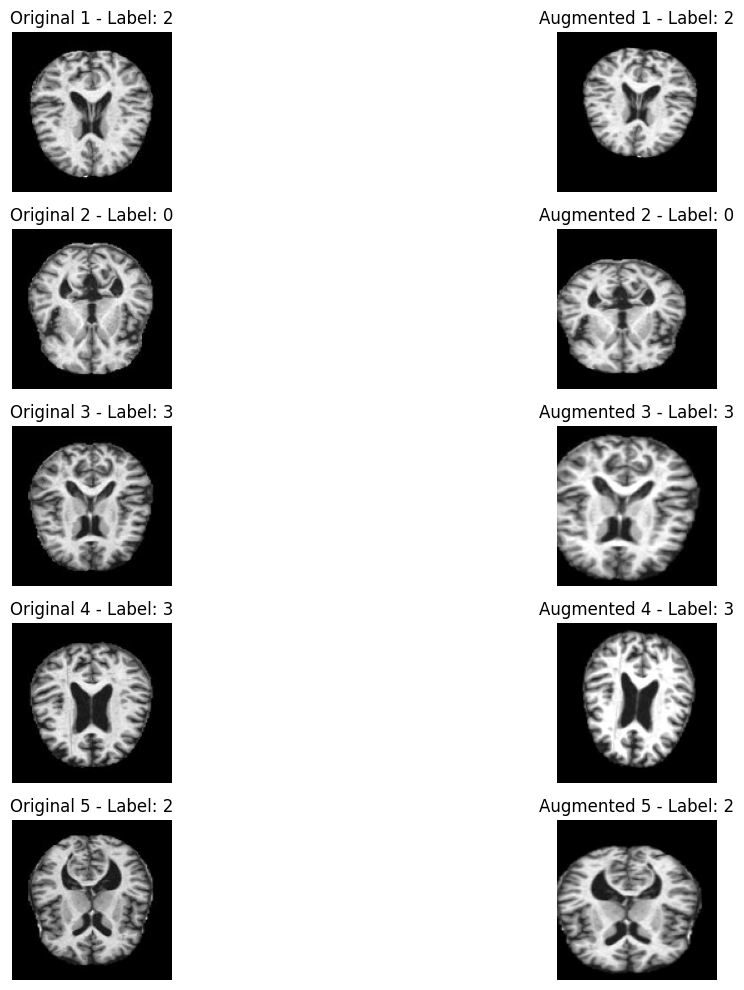

In [ ]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageOps

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define augmentation transformations for grayscale images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,       # Randomly rotate by up to 15 degrees
    width_shift_range=0.1,   # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    horizontal_flip=True,    # Randomly flip horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    zoom_range=0.2,          # Randomly zoom by up to 20%
)

# Function to convert image to grayscale
def to_grayscale(image):
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[-1] == 3:  # If RGB, convert to grayscale
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    else:  # If PIL image, convert to grayscale
        image = ImageOps.grayscale(image)
    return image

# Function to apply augmentation to a grayscale image
def augment_image(image):
    # Convert image to NumPy array if necessary
    if not isinstance(image, np.ndarray):
        image = np.array(image)  # Convert PIL image to NumPy array

    # Ensure the image has a single channel (grayscale)
    if len(image.shape) == 2:  # If grayscale, add a channel dimension
        image = np.expand_dims(image, axis=-1)  # Shape: (height, width, 1)

    # Add batch dimension: (1, height, width, 1)
    image = np.expand_dims(image, axis=0)

    # Apply augmentation
    augmented_image = next(datagen.flow(image, batch_size=1))[0]  # Use next() to get the augmented image
    return augmented_image

# Display original and augmented grayscale images with labels
plt.figure(figsize=(15, 10))
for i in range(5):  # Show 5 examples
    # Original image
    original_image = dataset[i]['image']  # Replace 'image' with the correct key
    label = dataset[i]['label']  # Replace 'label' with the correct key

    # Convert original image to grayscale
    original_grayscale = to_grayscale(original_image)

    # Display original grayscale image
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(original_grayscale, cmap='gray')
    plt.title(f"Original {i+1} - Label: {label}")
    plt.axis('off')

    # Augmented grayscale image
    augmented_image = augment_image(original_grayscale)
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(augmented_image.squeeze(), cmap='gray')  # Remove extra dimensions and display
    plt.title(f"Augmented {i+1} - Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Augmented label distribution: Counter({2: 2566, 3: 1781, 0: 724, 1: 49})


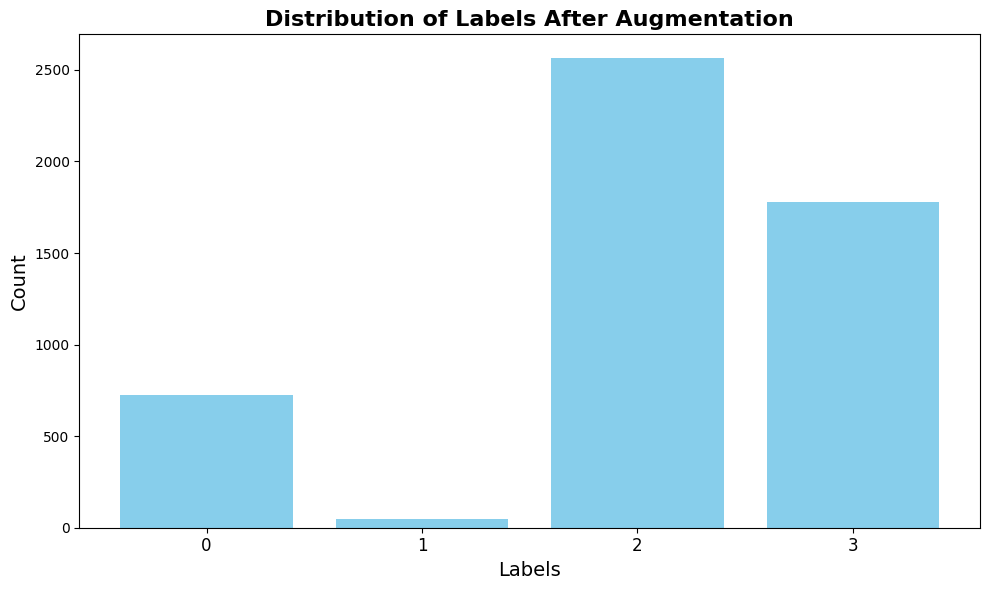

In [ ]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import ImageOps

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define augmentation transformations for grayscale images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,       # Randomly rotate by up to 15 degrees
    width_shift_range=0.1,   # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    horizontal_flip=True,    # Randomly flip horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    zoom_range=0.2,          # Randomly zoom by up to 20%
)

# Function to convert image to grayscale
def to_grayscale(image):
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[-1] == 3:  # If RGB, convert to grayscale
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    else:  # If PIL image, convert to grayscale
        image = ImageOps.grayscale(image)
    return image

# Function to apply augmentation to a grayscale image
def augment_image(image):
    # Convert image to NumPy array if necessary
    if not isinstance(image, np.ndarray):
        image = np.array(image)  # Convert PIL image to NumPy array

    # Ensure the image has a single channel (grayscale)
    if len(image.shape) == 2:  # If grayscale, add a channel dimension
        image = np.expand_dims(image, axis=-1)  # Shape: (height, width, 1)

    # Add batch dimension: (1, height, width, 1)
    image = np.expand_dims(image, axis=0)

    # Apply augmentation
    augmented_image = next(datagen.flow(image, batch_size=1))[0]  # Use next() to get the augmented image
    return augmented_image

# Augment the dataset and collect labels
augmented_labels = []
for example in dataset:
    original_image = example['image']  # Replace 'image' with the correct key
    label = example['label']  # Replace 'label' with the correct key

    # Convert original image to grayscale
    original_grayscale = to_grayscale(original_image)

    # Augment the grayscale image
    augmented_image = augment_image(original_grayscale)

    # Append the label to the augmented_labels list
    augmented_labels.append(label)

# Count the occurrences of each label in the augmented dataset
augmented_label_counts = Counter(augmented_labels)

# Print the label distribution
print("Augmented label distribution:", augmented_label_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(augmented_label_counts.keys(), augmented_label_counts.values(), color='skyblue')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels After Augmentation', fontsize=16, fontweight='bold')

# Customize x-axis to show only integer labels
plt.xticks(list(augmented_label_counts.keys()), fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

> The augmentation process is not modifying the dataset or the labels. This happens because:

1. The augmentation is applied to the images, but the labels remain unchanged.

2. The augmented images are not being saved or used to update the dataset.



### Steps:
- Define Augmentation Ratios:

For each class, specify how many augmented images to generate per original image.

- Apply Augmentation:

For each image in the dataset, generate the specified number of augmented images based on its class.

- Collect Augmented Images and Labels:

Store the augmented images and their corresponding labels.

- Visualize the Distribution:

Plot the distribution of labels in the augmented dataset.

Augmented label distribution: Counter({3: 5343, 2: 5132, 0: 5068, 1: 4998})


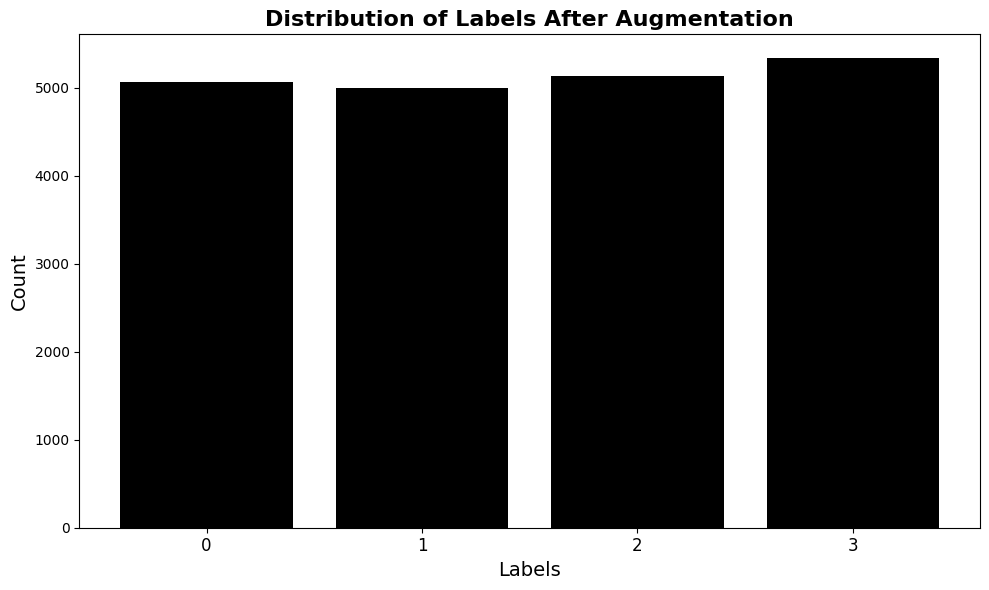

In [ ]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from PIL import ImageOps

# Load the Falah/Alzheimer_MRI dataset
dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

# Define augmentation transformations for grayscale images
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,       # Randomly rotate by up to 15 degrees
    width_shift_range=0.1,   # Randomly shift width by up to 10%
    height_shift_range=0.1,  # Randomly shift height by up to 10%
    horizontal_flip=True,    # Randomly flip horizontally
    brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    zoom_range=0.2,          # Randomly zoom by up to 20%
)

# Function to convert image to grayscale
def to_grayscale(image):
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[-1] == 3:  # If RGB, convert to grayscale
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    else:  # If PIL image, convert to grayscale
        image = ImageOps.grayscale(image)
    return image

# Function to apply augmentation to a grayscale image
def augment_image(image):
    # Convert image to NumPy array if necessary
    if not isinstance(image, np.ndarray):
        image = np.array(image)  # Convert PIL image to NumPy array

    # Ensure the image has a single channel (grayscale)
    if len(image.shape) == 2:  # If grayscale, add a channel dimension
        image = np.expand_dims(image, axis=-1)  # Shape: (height, width, 1)

    # Add batch dimension: (1, height, width, 1)
    image = np.expand_dims(image, axis=0)

    # Apply augmentation
    augmented_image = next(datagen.flow(image, batch_size=1))[0]  # Use next() to get the augmented image
    return augmented_image

# Define the number of augmented images to generate per class
augmentation_ratios = {
    0: 7,  # For class 0, generate 7 augmented images per original image
    1: 102,  # For class 1, generate 102 augmented images per original image
    2: 2,  # For class 2, generate 1 augmented image per original image
    3: 3,  # For class 3, generate 3 augmented images per original image
}

# Augment the dataset and collect labels
augmented_images = []
augmented_labels = []

for example in dataset:
    original_image = example['image']  # Replace 'image' with the correct key
    label = example['label']  # Replace 'label' with the correct key

    # Convert original image to grayscale
    original_grayscale = to_grayscale(original_image)

    # Generate augmented images based on the class
    num_augmented = augmentation_ratios.get(label, 1)  # Default to 1 if label not in augmentation_ratios
    for _ in range(num_augmented):
        augmented_image = augment_image(original_grayscale)
        augmented_images.append(augmented_image)
        augmented_labels.append(label)

# Count the occurrences of each label in the augmented dataset
augmented_label_counts = Counter(augmented_labels)

# Print the label distribution
print("Augmented label distribution:", augmented_label_counts)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(augmented_label_counts.keys(), augmented_label_counts.values(), color='black')

# Add labels and title
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Labels After Augmentation', fontsize=16, fontweight='bold')

# Customize x-axis to show only integer labels
plt.xticks(list(augmented_label_counts.keys()), fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

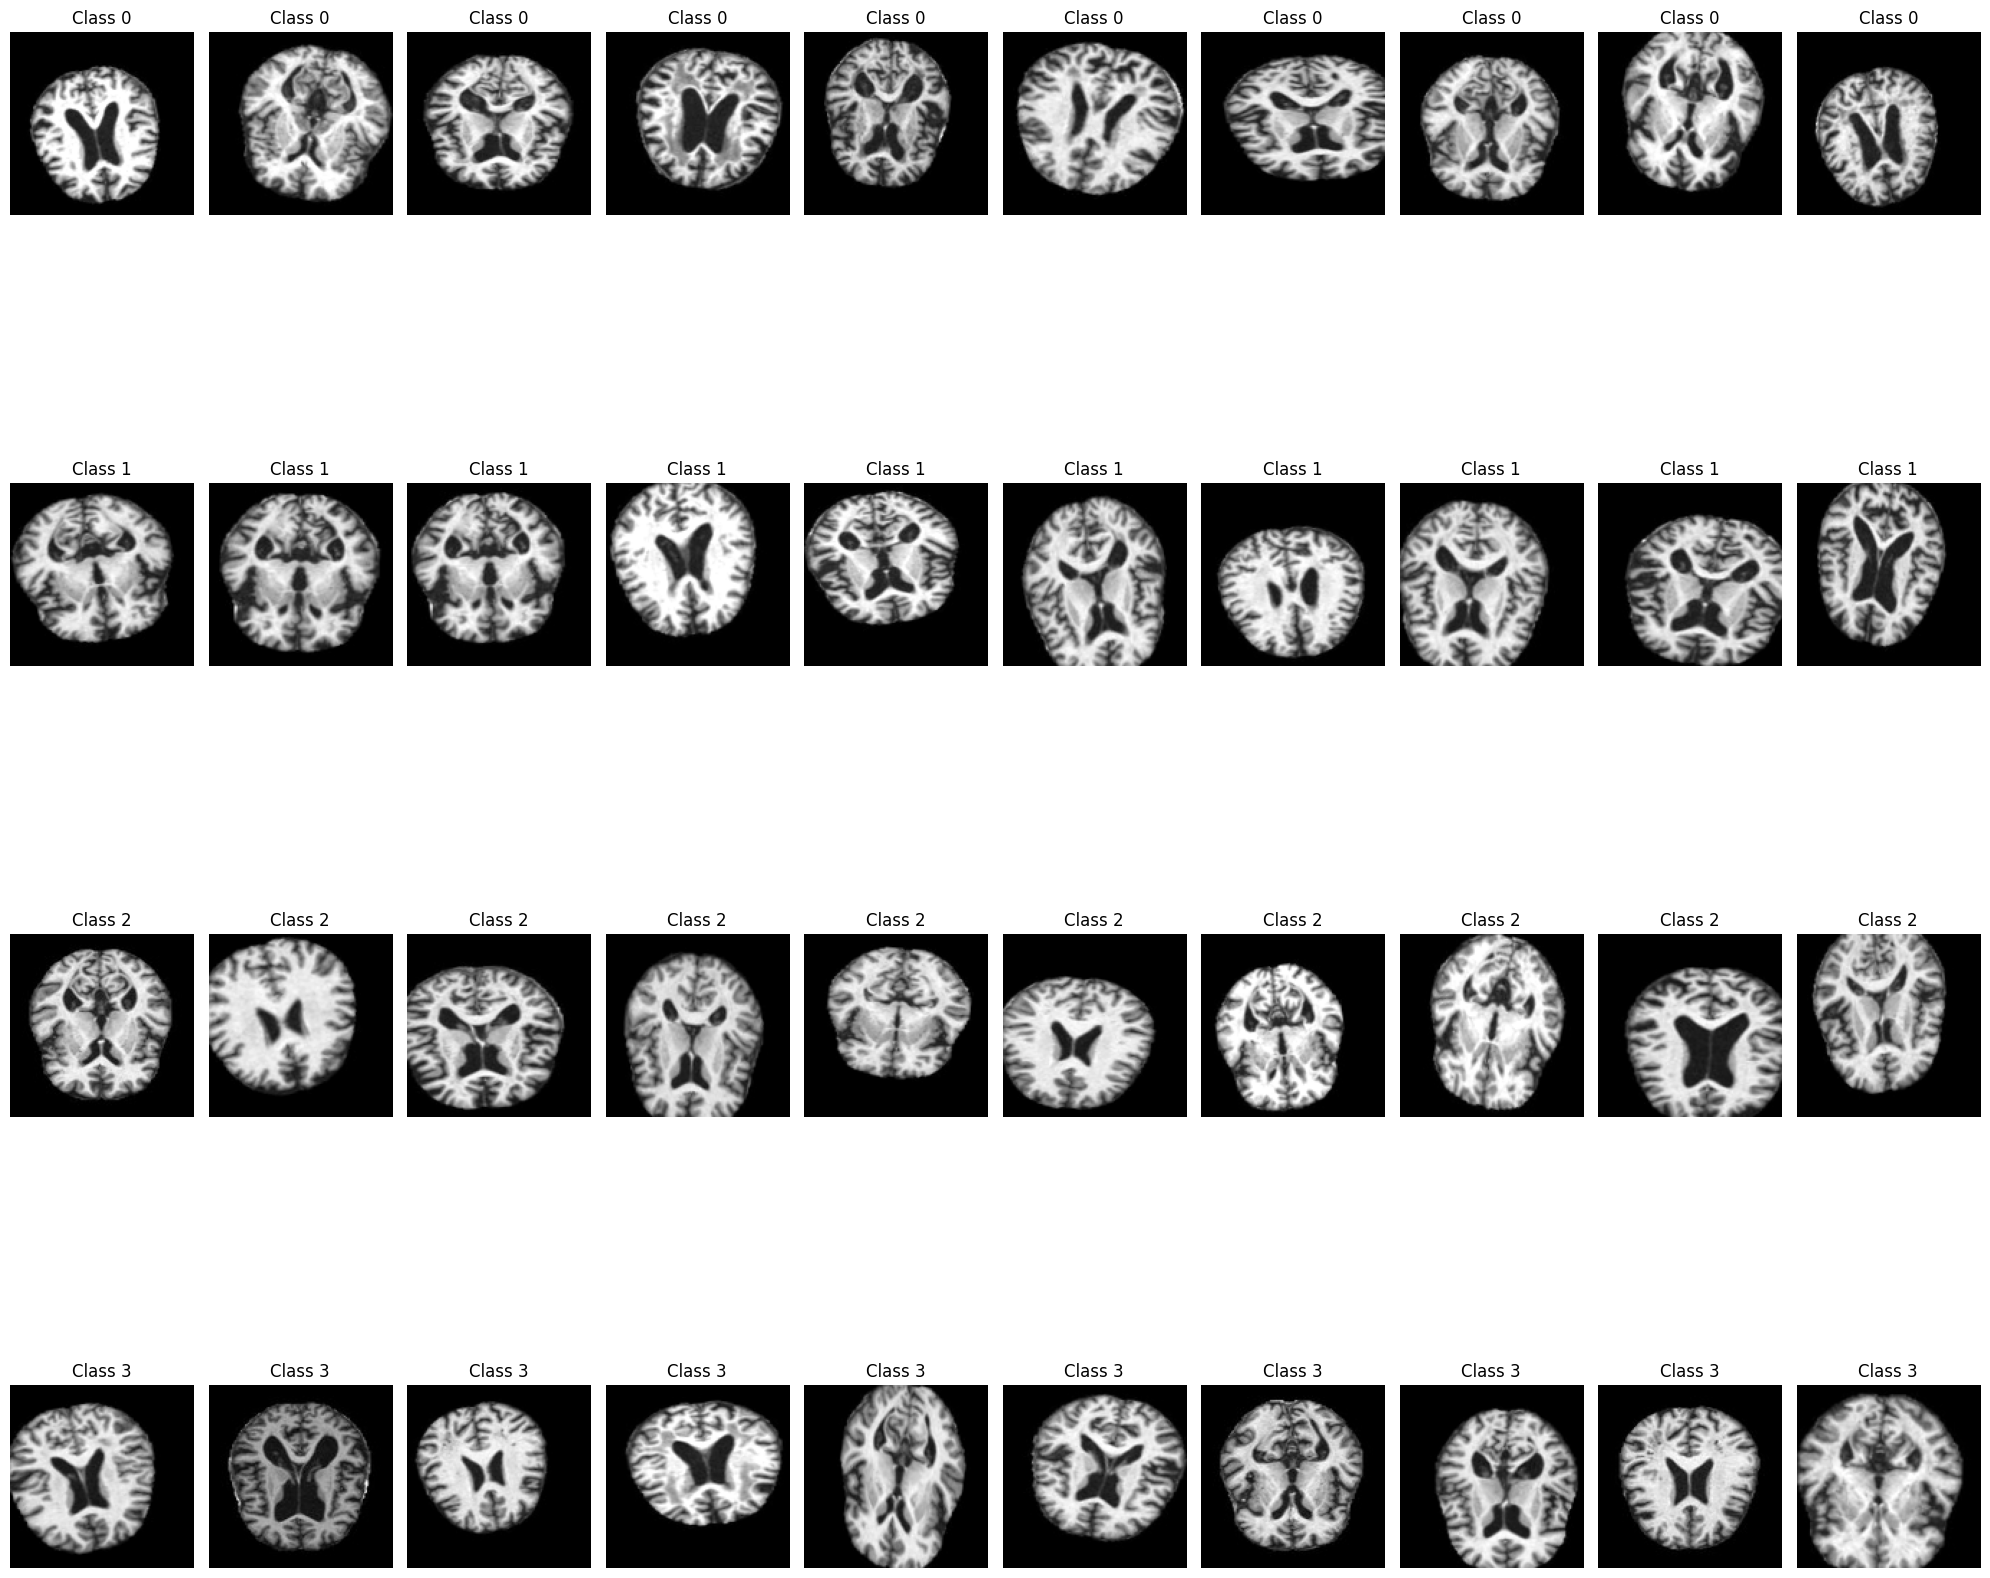

In [ ]:
from collections import defaultdict
import random

# Combine original and augmented data
all_images = list(dataset['image']) + augmented_images
all_labels = list(dataset['label']) + augmented_labels

# Separate images by class
class_images = defaultdict(list)
for image, label in zip(all_images, all_labels):
    class_images[label].append(image)

# Randomly sample 10 images from each class
sampled_images = {}
for label, images in class_images.items():
    sampled_images[label] = random.sample(images, min(10, len(images)))  # Sample 10 images or all if less than 10

# Display sampled images
plt.figure(figsize=(20, 20))
for label, images in sampled_images.items():
    for i, image in enumerate(images):
        plt.subplot(4, 10, label * 10 + i + 1)  # Arrange in a grid (4 classes x 10 images)
        plt.imshow(image, cmap='gray')
        plt.title(f"Class {label}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Implementing a Diffusion Model

### Steps:
- Define the Diffusion Model:

Use a diffusion model to learn meaningful representations of the input images.

- Add a Classifier:

Add a simple classifier (e.g., a fully connected layer) on top of the diffusion model to perform classification.

- Train the Model:

Train the diffusion model and classifier jointly.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define a directory in Google Drive to save checkpoints
checkpoint_dir = "/content/drive/My Drive/checkpoints"  # Change this to your desired folder
os.makedirs(checkpoint_dir, exist_ok=True)

# Combine original and augmented data
all_images = list(dataset['image']) + augmented_images  # Replace 'image' with the correct key
all_labels = list(dataset['label']) + augmented_labels  # Replace 'label' with the correct key

# Normalize and convert to tensors
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Convert images and labels to PyTorch tensors
images = [transform(image) for image in all_images]
images = torch.stack(images)
labels = torch.tensor(all_labels, dtype=torch.long)

# Create a PyTorch dataset and dataloader
combined_dataset = TensorDataset(images, labels)
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Define the diffusion model (simplified for demonstration)
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (64, 64, 64)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (128, 32, 32)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (256, 16, 16)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        return self.fc(x)

# Combine diffusion model and classifier
class DiffusionClassifier(nn.Module):
    def __init__(self, diffusion_model, classifier):
        super(DiffusionClassifier, self).__init__()
        self.diffusion_model = diffusion_model
        self.classifier = classifier

    def forward(self, x):
        features = self.diffusion_model.encoder(x)
        features = features.view(features.size(0), -1)  # Flatten features
        return self.classifier(features)

# Initialize models
diffusion_model = DiffusionModel()

# Calculate the correct input_dim for the classifier
dummy_input = torch.randn(1, 1, 128, 128)  # Adjust input size based on your image size
with torch.no_grad():
    dummy_output = diffusion_model.encoder(dummy_input)
    input_dim = dummy_output.view(1, -1).size(1)  # Flatten and get the size

print(f"Input dimension for classifier: {input_dim}")  # Debugging: Print the input_dim

classifier = Classifier(input_dim=input_dim, num_classes=4)  # Use the correct input_dim
model = DiffusionClassifier(diffusion_model, classifier)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to save a checkpoint
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Function to load a checkpoint
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {checkpoint_path} (epoch {epoch}, loss {loss})")
    return epoch

# Training loop
num_epochs = 10
start_epoch = 0

# Load the latest checkpoint if available
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")]
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split("_")[2].split(".")[0]))
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    start_epoch = load_checkpoint(latest_checkpoint_path, model, optimizer) + 1

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Save checkpoint after each epoch
    save_checkpoint(epoch, model, optimizer, running_loss / len(dataloader), checkpoint_dir)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete!")

Mounted at /content/drive
Input dimension for classifier: 65536


100%|██████████| 802/802 [40:43<00:00,  3.05s/it]


Checkpoint saved at /content/drive/My Drive/checkpoints/checkpoint_epoch_0.pth
Epoch [1/10], Loss: 5.3306


 40%|████      | 321/802 [17:48<26:12,  3.27s/it]

# New Model

In [ ]:
import numpy as np
import torch
from PIL import Image

def preprocess_images(images, target_size=(128, 128)):
    """
    Robust image preprocessing for Alzheimer's dataset

    Args:
    - images: List or array of input images
    - target_size: Desired output image size

    Returns:
    - Numpy array of processed images
    """
    processed_images = []

    for img in images:
        # Handle different input types
        if isinstance(img, np.ndarray):
            # Squeeze and remove extra dimensions
            while img.ndim > 2:
                img = img.squeeze(axis=-1)

            # Convert to PIL if 2D numpy array
            if img.ndim == 2:
                img = Image.fromarray(img.astype(np.uint8))
            else:
                raise ValueError(f"Unexpected image shape: {img.shape}")

        # Ensure PIL Image
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))

        # Resize and convert to grayscale
        img = img.convert('L')
        img = img.resize(target_size, Image.LANCZOS)

        # Convert to numpy array
        img_array = np.array(img).astype(np.float32)
        processed_images.append(img_array)

    # Stack images into a single numpy array
    return np.stack(processed_images)

# Usage example:
processed_images = preprocess_images(all_images)
processed_labels = np.array(all_labels)

In [ ]:
print(processed_images.shape)
print(processed_labels.shape)

(25661, 128, 128)
(25661,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

class AlzheimerClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x.unsqueeze(1))
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def train_model(processed_images, processed_labels):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        processed_images, processed_labels, test_size=0.2, random_state=42
    )

    # Convert to tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    # Create datasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AlzheimerClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    model.train()
    for epoch in range(10):
        total_loss = 0
        for batch_imgs, batch_labels in train_loader:
            batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_imgs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    # Evaluation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in test_loader:
            batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
            outputs = model(batch_imgs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(batch_labels.cpu().numpy())

    # Print metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))

    print("\nConfusion Matrix:")
    print(confusion_matrix(true_labels, predictions))

    return model

# Usage
model = train_model(processed_images, processed_labels)

Epoch 1, Loss: 1.6052646711236591
Epoch 2, Loss: 1.2788366985469592
Epoch 3, Loss: 1.2806654975421703
Epoch 4, Loss: 1.2285615077642638
Epoch 5, Loss: 1.1758248031696426
Epoch 6, Loss: 1.145269504310186
Epoch 7, Loss: 1.1328783917278515
Epoch 8, Loss: 1.1271550378695456
Epoch 9, Loss: 1.1181423391137169
Epoch 10, Loss: 1.1125992638671138

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.02      0.05      1152
           1       0.98      0.93      0.95      1045
           2       0.78      0.54      0.64      1501
           3       0.40      0.83      0.54      1435

    accuracy                           0.58      5133
   macro avg       0.62      0.58      0.54      5133
weighted avg       0.61      0.58      0.54      5133


Confusion Matrix:
[[  28   10    4 1110]
 [  43  970    0   32]
 [   6    4  813  678]
 [  11    6  229 1189]]


## NEW

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

Initial Label Distribution: Counter({2: 2566, 3: 1781, 0: 724, 1: 49})
Augmented Label Distribution: Counter({2: 7698, 3: 7124, 0: 5792, 1: 5047})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s]


Epoch 1/10, Loss: 0.5552, Accuracy: 0.7584
Epoch 2/10, Loss: 0.2080, Accuracy: 0.9236
Epoch 3/10, Loss: 0.1069, Accuracy: 0.9620
Epoch 4/10, Loss: 0.0852, Accuracy: 0.9706
Epoch 5/10, Loss: 0.0606, Accuracy: 0.9798
Epoch 6/10, Loss: 0.0478, Accuracy: 0.9835
Epoch 7/10, Loss: 0.0484, Accuracy: 0.9834
Epoch 8/10, Loss: 0.0432, Accuracy: 0.9852
Epoch 9/10, Loss: 0.0446, Accuracy: 0.9850
Epoch 10/10, Loss: 0.0365, Accuracy: 0.9878


<ipython-input-3-41276221bc2a>:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.softmax(torch.tensor(outputs), dim=1).cpu().numpy(),


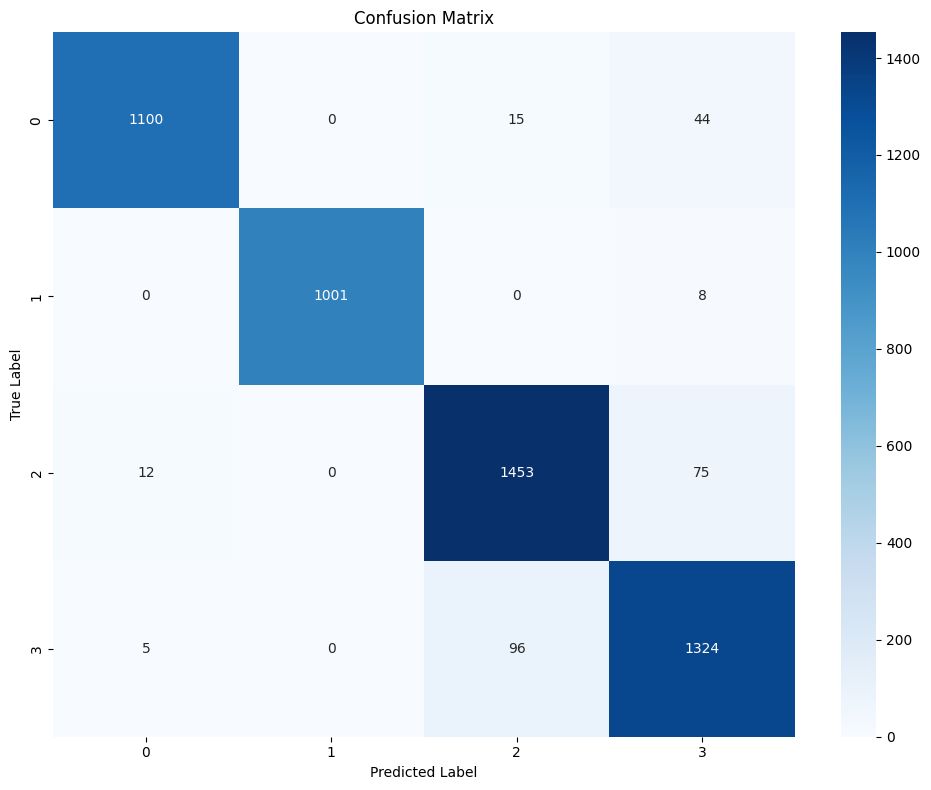

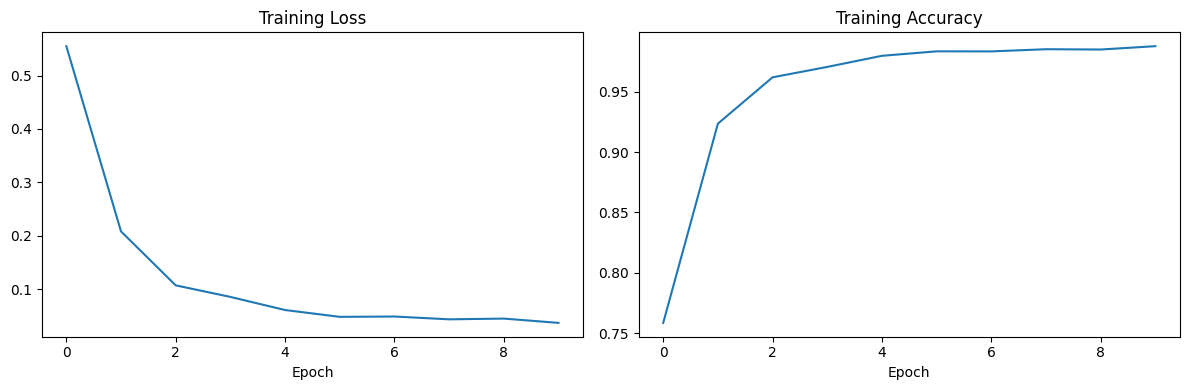


Model Evaluation Metrics:
ACCURACY: 0.9503214494447692
PRECISION: 0.9509720990810624
RECALL: 0.9503214494447692
F1_SCORE: 0.9505316406280725
AUC: None
MCC: 0.9331793308773363


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    matthews_corrcoef,
    confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import tensorflow as tf
from collections import Counter
from datasets import load_dataset

# Step 3: Data Augmentation
def to_grayscale(image):
    if isinstance(image, np.ndarray):
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
    else:
        image = ImageOps.grayscale(image)
    return image

def augment_image(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)

    image = np.expand_dims(image, axis=0)

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
    )

    augmented_image = next(datagen.flow(image, batch_size=1))[0]
    return augmented_image

def augment_dataset(dataset):
    augmentation_ratios = {0: 7, 1: 102, 2: 2, 3: 3}
    augmented_images, augmented_labels = [], []

    for example in dataset:
        original_image = example['image']
        label = example['label']

        original_grayscale = to_grayscale(original_image)
        num_augmented = augmentation_ratios.get(label, 1)

        for _ in range(num_augmented):
            augmented_image = augment_image(original_grayscale)
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return augmented_images, augmented_labels

# Step 4-5: Data Preparation and Preprocessing
class AlzheimerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = [np.array(img) if isinstance(img, Image.Image) else img for img in images]
        self.labels = labels

        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.Grayscale(3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if not isinstance(image, np.ndarray):
            image = np.array(image)

        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        if image.shape[-1] == 3:
            image = image[:,:,0]

        image = image.astype(np.uint8)

        transformed_image = self.transform(image)
        label = self.labels[idx]
        return transformed_image, label

# Step 6: Model Definition
class AlzheimerClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# Step 7-8: Training and Evaluation
def train_and_evaluate(all_images, all_labels, test_size=0.2, random_state=42):
    train_images, test_images, train_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=test_size, random_state=random_state, stratify=all_labels
    )

    train_dataset = AlzheimerDataset(train_images, train_labels)
    test_dataset = AlzheimerDataset(test_images, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AlzheimerClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    epochs = 10
    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / len(train_dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    try:
        auc = roc_auc_score(
            torch.nn.functional.one_hot(torch.tensor(all_labels)).numpy(),
            torch.nn.functional.softmax(torch.tensor(outputs), dim=1).cpu().numpy(),
            multi_class='ovr'
        )
    except:
        auc = None

    mcc = matthews_corrcoef(all_labels, all_preds)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Training Metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'mcc': mcc
    }

def main():
    # Load dataset
    dataset = load_dataset('Falah/Alzheimer_MRI', split='train')

    # Print initial label distribution
    initial_labels = [example['label'] for example in dataset]
    print("Initial Label Distribution:", Counter(initial_labels))

    # Augment dataset
    augmented_images, augmented_labels = augment_dataset(dataset)

    # Combine original and augmented data
    all_images = list(dataset['image']) + augmented_images
    all_labels = initial_labels + augmented_labels

    print("Augmented Label Distribution:", Counter(all_labels))

    # Train and evaluate
    metrics = train_and_evaluate(all_images, all_labels)

    print("\nModel Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value}")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, matthews_corrcoef, confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import tensorflow as tf
from collections import Counter
from datasets import load_dataset

# Step 3: Data Augmentation (same as before)
# ...

# Step 4-5: Data Preparation and Preprocessing (same as before)
# ...

# Step 6: Model Definition (same as before)
# ...

# Step 7-8: Training and Evaluation
def train_and_evaluate(train_images, train_labels, test_images, test_labels):
    train_dataset = AlzheimerDataset(train_images, train_labels)
    test_dataset = AlzheimerDataset(test_images, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AlzheimerClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    epochs = 5
    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / len(train_dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')

    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

    try:
        auc = roc_auc_score(
            torch.nn.functional.one_hot(torch.tensor(all_labels)).numpy(),
            torch.nn.functional.softmax(torch.tensor(outputs), dim=1).cpu().numpy(),
            multi_class='ovr'
        )
    except:
        auc = None

    mcc = matthews_corrcoef(all_labels, all_preds)

    # Confusion Matrix and Training Metrics Plotting (same as before)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'mcc': mcc
    }

def main():
    # Load training and test datasets
    train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
    test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

    # Augment training dataset
    augmented_train_images, augmented_train_labels = augment_dataset(train_dataset)

    # Combine original and augmented training data
    all_train_images = list(train_dataset['image']) + augmented_train_images
    all_train_labels = list(train_dataset['label']) + augmented_train_labels

    # Prepare test dataset
    test_images = list(test_dataset['image'])
    test_labels = list(test_dataset['label'])

    # Train and evaluate
    metrics = train_and_evaluate(all_train_images, all_train_labels, test_images, test_labels)

    print("\nModel Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric.upper()}: {value}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.5196, Accuracy: 0.7813
Epoch 2/5, Loss: 0.1739, Accuracy: 0.9346
Epoch 3/5, Loss: 0.0951, Accuracy: 0.9671
Epoch 4/5, Loss: 0.0681, Accuracy: 0.9772
Epoch 5/5, Loss: 0.0607, Accuracy: 0.9793

Model Evaluation Metrics:
ACCURACY: 0.97109375
PRECISION: 0.9716354082898306
RECALL: 0.97109375
F1_SCORE: 0.9709843277458052
AUC: None
MCC: 0.9525405182422392


<ipython-input-4-2b0ad6186515>:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.nn.functional.softmax(torch.tensor(outputs), dim=1).cpu().numpy(),
